<b>Ionosphere Data Set</b> 
(reference to UCI Machine Learning Repository <a href="https://archive.ics.uci.edu/ml/datasets/ionosphere">description</a>)


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8

import numpy as np
np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

import pandas as pd
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 200)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision', 6)

import seaborn as sns
sns.set()

from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

from lib.utils import *
from lib.outlierdetection import *

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2018-09-13 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.2
torch 0.4.0a0+9692519
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit

GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 56%


In [2]:
# Hyperparameters
HP = HYPERPARAMETERS({
    "SEED"                : 0
})

In [3]:
# Seed random generators for repro 
np.random.seed(HP.SEED)  

In [4]:
# load dataset https://archive.ics.uci.edu/ml/datasets/ionosphere
data = pd.read_csv("data/ionosphere.csv", header=None)
col_names = list(data.columns)
feature_names = list(col_names[:-1])
target_names = ['bad', 'good']

cols = list(data)
cols.insert(0, cols.pop(cols.index(34)))
data = data.loc[:, cols]
data.columns = col_names

feature_names, target_names

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33],
 ['bad', 'good'])

In [5]:
X = np.float32(data.drop(0, axis=1).values)
y = data[0].values   # conversion to int64 for pytorch

# Encode target class
encoder = LabelEncoder()
y = np.int64(encoder.fit_transform(y))
target_names = list(set(encoder.inverse_transform(y)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    shuffle=True, random_state=HP.SEED)

dataset_statistics(X_train, y_train, X_test, y_test, target_names)


Dataset statistics:
number of features:       34
number of classes:        2
data type:                float32
number of train samples:  280 (pos=184, neg=96, size=0MB)
number of test samples:   71 (pos=41, neg=30, size=0MB)
labels                    ['g', 'b']


In [6]:
from sklearn.ensemble import ExtraTreesClassifier
params = {
 'classifier__bootstrap': True,
 'classifier__max_depth': 15,
 'classifier__max_features': 'log2',
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 32}

pipeline = Pipeline(steps=[
              ('scaler',     StandardScaler(copy=True, with_mean=True, with_std=True)),
              ('outlier',    OutlierSampler(8.5)),
              ('sampler',    SMOTE(random_state=HP.SEED)),
              ('classifier', ExtraTreesClassifier())
])

pipeline.set_params(**params)

scoring = 'f1'

for pip_name in pipeline.named_steps:
    display(pipeline.named_steps[pip_name])

StandardScaler(copy=True, with_mean=True, with_std=True)

OutlierSampler(memory=None, threshold=8.5, verbose=0)

SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=0, ratio='auto', svm_estimator=None)

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=15, max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

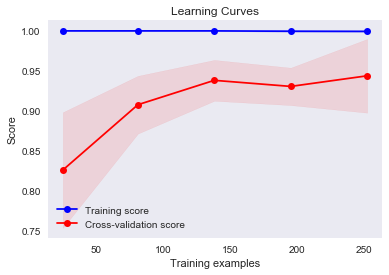

In [7]:
cv = KFold(n_splits=10, shuffle=True, random_state=HP.SEED).split(X_train)
_ = plot_learning_curve(pipeline, 'Learning Curves', X_train, y_train, 
                    cv=cv, scoring=scoring, shuffle=True, random_state=HP.SEED)

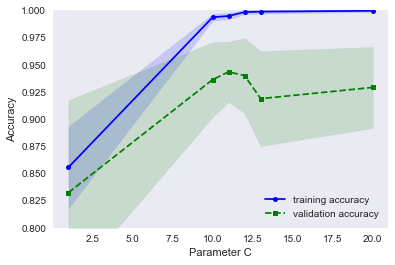

In [8]:
from sklearn.model_selection import validation_curve
param_name = 'classifier__max_depth'
param_range = [ 1, 10, 11, 12, 13, 20]
train_scores, test_scores = validation_curve(
                estimator=pipeline,
                 X=X_train,
                 y=y_train,
                 param_name=param_name,
                 scoring='accuracy',
                 param_range=param_range,
                 cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(param_range, train_mean,
          color='blue', marker='o',
          markersize=5,
          label='training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                  train_mean - train_std, alpha=0.15,
                  color='blue')
plt.plot(param_range, test_mean,
          color='green', linestyle='--',
          marker='s', markersize=5,
          label='validation accuracy')
plt.fill_between(param_range,
                  test_mean + test_std,
                  test_mean - test_std,
                  alpha=0.15, color='green')
plt.grid()
#plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

Trainings score: 1.0 0.0
Validation score: 0.9489499284824413 0.024050436881000534


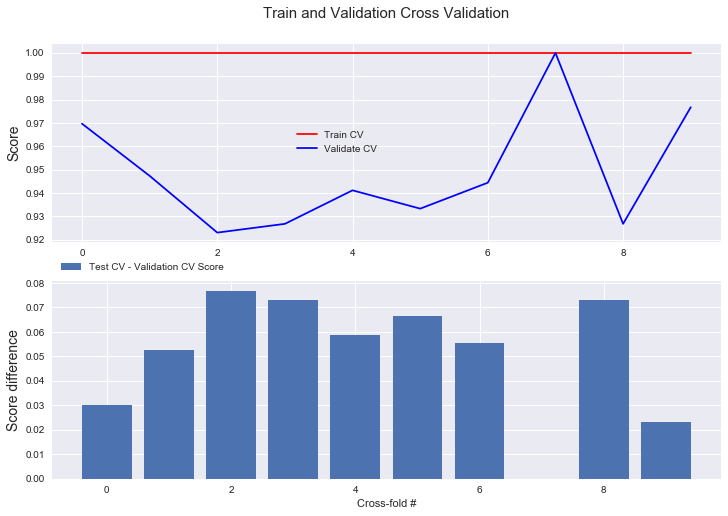

In [9]:
# Cross-validate to train best model 

cv = KFold(n_splits=10, shuffle=True, random_state=HP.SEED).split(X_train)
scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True, 
                        verbose=0, n_jobs=-1)

print("Trainings score:", np.mean(scores['train_score']), np.std(scores['train_score']))
print("Validation score:", np.mean(scores['test_score']), np.std(scores['test_score']))
plot_cross_validation_scores(scores, figsize=(12, 8))

In [10]:
# http://www.ritchieng.com/machine-learning-evaluate-classification-model/
# https://github.com/justmarkham/DAT8/blob/master/other/model_evaluation_comparison.md\
# Accuracy of a model that simply counts, i.e. looks at the prior distribution

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
try:
    y_prob = pipeline.predict_proba(X_test)
except:
    pass

print('Confusion Matrix\n', metrics.confusion_matrix(y_test, y_pred))  # Confusion Matrix
print('Accuracy ', metrics.accuracy_score(y_test, y_pred))            # Accuracy (TP + TN) / float(TP + TN + FP + FN)
print('Recall   ', metrics.recall_score(y_test, y_pred))                # Recall (Sensitivity)   TP / float(FN + TP)
print('Precision', metrics.precision_score(y_test, y_pred))     
print('F1       ', metrics.f1_score(y_test, y_pred))     
print('ROC AUC  ', metrics.roc_auc_score(y_test, y_pred))     

Confusion Matrix
 [[28  2]
 [ 0 41]]
Accuracy  0.971830985915493
Recall    1.0
Precision 0.9534883720930233
F1        0.9761904761904763
ROC AUC   0.9666666666666667


In [11]:
#  Cross-validate score on test set
cv = KFold(n_splits=10, shuffle=True, random_state=HP.SEED).split(X_test)
scores = cross_val_score(pipeline, X_test, y_test, cv=cv,  scoring="accuracy",  verbose=0, n_jobs=-1)

print("Test accuracy score:", np.mean(scores), np.std(scores))

Test accuracy score: 0.9571428571428573 0.06546536707079774


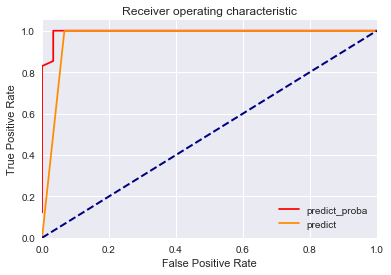

In [12]:
try:
    plot_roc_curve(y_test, y_pred, y_prob)
except:
    pass

In [13]:
lines = classification_report(y_test, y_pred, target_names=target_names).split('\n')

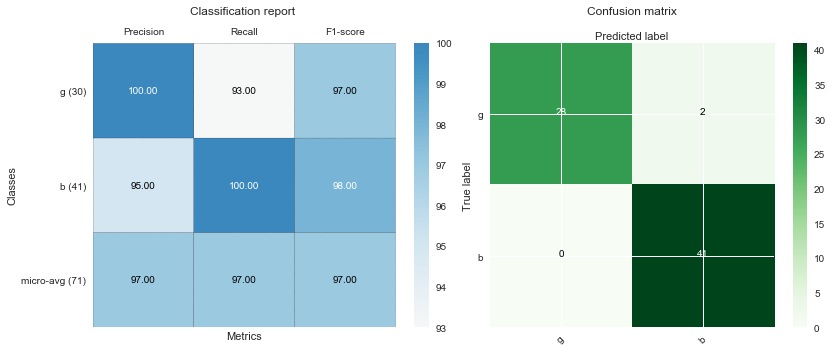

In [14]:
plot_classifier_summary(y_test, y_pred, target_names)

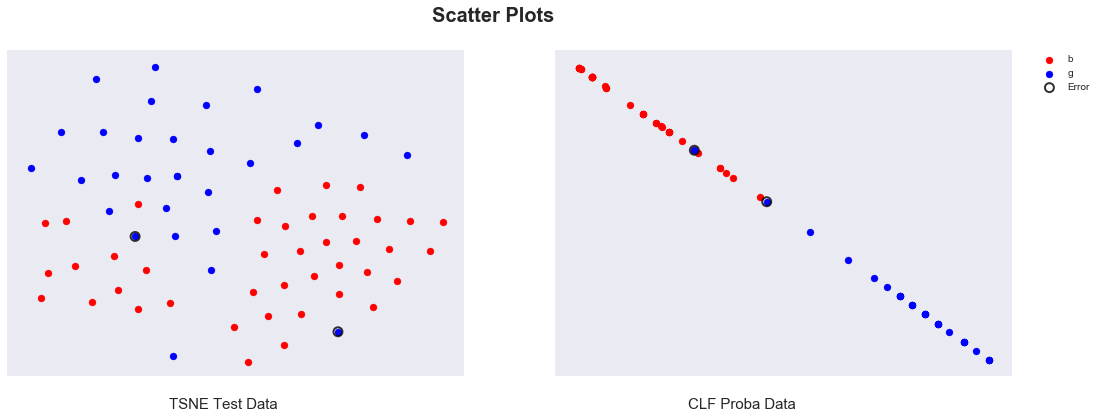

In [15]:
try:
    plot_scatter_plots(X_test, y_pred, y_prob, y_test, target_names, figsize=(18,6))
except:
    pass

In [16]:
# Check classification of full data set
classifier_summary_report(X, y, pipeline.predict(X), target_names)

Note: weighted average f1-score 
              precision    recall  f1-score   support

          g       1.00      0.98      0.99       126
          b       0.99      1.00      1.00       225

avg / total       0.99      0.99      0.99       351



'Data points=351'

'Features=34'

'Class dist.=0.641026'

'F1 valid=0.995575'

'ACC=0.994302'

'ROC_AUC=0.992063'

'LOG_LOSS=0.196807'

'Misclassified=2'

'Data points=[65, 89]'